In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import librosa
import librosa.display
import os
import re
import shutil
import random
import math
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn as sk
from util.IO import *
from util.AudioData import SongData, SegmentSpectrumData
from util.Visualizations import print_song_info
from model.FeatureExtraction import *
from model.Simple import SimpleTestNet
from model.Reference import KeyNet
from model.Experimental import SplitNet, ColNet
from model.SpectralDataset import SpectralDataset, SpectralDatasetBase, SpectralDataset30sec, SpectralDatasetSegmented
from sklearn import preprocessing as pp
from sklearn.model_selection import KFold

# Loading

We start by configuring the source locations and loading the data

In [3]:
root_folder = "D:\Programming\_Projects\TU Wien - Data Science\WS 2022\ADL\\adl_ws22\\"

# Evaluation
eval_folder = root_folder + "eval\\"
data_folder = root_folder + "data\\"
model_folder = root_folder + "model\\"

# Audio
giantsteps_data_folder = data_folder + "giantsteps\\"
giantsteps_mtg_data_folder = data_folder + "giantsteps-mtg\\"
conversion_subfolder = "converted\\"

# Annotations
giantsteps_key_folder = eval_folder + "giantsteps_annotations\\key\\"
giantsteps_mtg_key_file = eval_folder + "giantsteps-mtg_annotations.txt"

In [4]:
giantsteps_keys = load_giantsteps_keys(giantsteps_key_folder)
giantsteps_mtg_keys = load_giantsteps_mtg_keys(giantsteps_mtg_key_file)

If the script cannot load 100% of files, execute the following segment to reformat the mp3 files to wav.

In [5]:
convert_mp3_to_wav(giantsteps_data_folder, giantsteps_data_folder+conversion_subfolder)
convert_mp3_to_wav(giantsteps_mtg_data_folder, giantsteps_mtg_data_folder+conversion_subfolder)

KeyboardInterrupt: 

Load the sample information

In [5]:
giantsteps_data = load_audio_data(giantsteps_data_folder+conversion_subfolder, giantsteps_keys)
giantsteps_mtg_data = load_audio_data(giantsteps_mtg_data_folder+conversion_subfolder, giantsteps_mtg_keys)


KeyboardInterrupt



# Feature extraction

I implement some base features to extract data from the given samples:
1. constant Q-transform spectrum as demonstrated by the reference project
2. Slightly modified Qt spectrum that focuses on the fundamental frequencies
3. A method to extract a random 30 second sample window

Some utility functions for the spectographs.
1. Resize all spectrographs by either cutting away excess columns, or repeating the spectograph from the start until filled.
2. Generate a spectograph equivalent to 30 seconds by randomly piecing together 5-second segments from the original spectograph (as a kind of bootstrap-based data-enhancement method).

Extracting the various styles of spectograph and storing them with my song data object

In [5]:
giantsteps_data = parse_song_data(giantsteps_data)
giantsteps_mtg_data = parse_song_data(giantsteps_mtg_data)

KeyboardInterrupt: 

In [146]:
for sid in giantsteps_data.keys():
    #song = giantsteps_data[sid]
    print(song.qt_spec_resized.shape)
    #song.sid = sid

(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)
(192, 646)

Storing the data for reuse.

In [29]:
# Store
store_pickle(giantsteps_data, data_folder + "giantsteps_data.obj")
store_pickle(giantsteps_mtg_data, data_folder + "giantsteps_mtg_data.obj")

In [6]:
# Load
giantsteps_data = load_pickle(data_folder + "giantsteps_data.obj")
#giantsteps_mtg_data = load_pickle(data_folder + "giantsteps_mtg_data.obj")

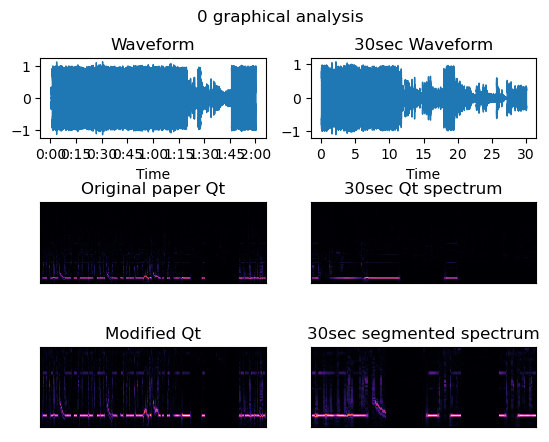

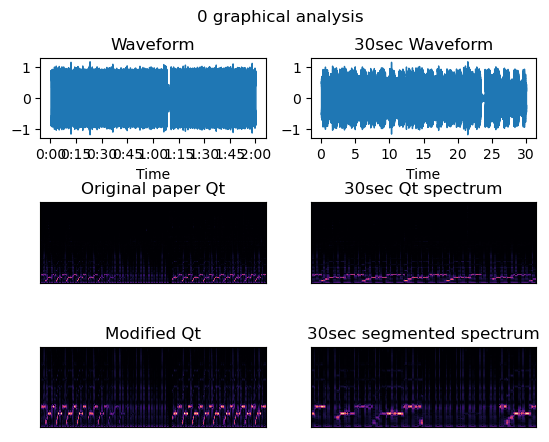

In [7]:
sid_sample = random.sample(list(giantsteps_data.keys()), k=2)
for sid in sid_sample:
     print_song_info(giantsteps_data[sid])

In [50]:
# giantsteps_data['1695408'].qt_spec_30sec.shape == giantsteps_data['1695408'].segmented_specs[0].shape
giantsteps_data['1695408'].segment_specs[0].spec.shape
giantsteps_data['1695408'].qt_spec_resized.shape

(192, 646)

Inputs:
1. Full inputs, pad smaller inputs by repeating the spectrum
2. Smaller windows of inputs
3. Data enhancement methods:

# Neural Network

The network architecture is based on InceptionKeyNet. However, as I kept adding the blocks, it seemed performance degrades. Likely, the architecture is overkill. I assume the task of identifying musical keys depends on a few base frequencies and cna be done with a more general network architecture.

Splitting train, test and validation indices

In [9]:
# Datasets
train_frac = 0.8
val_frac_of_train = 0.2
num_samples = len(giantsteps_data.keys())
num_train_samples = round(num_samples * train_frac)
num_val_samples = round(num_train_samples * val_frac_of_train)

partition = dict()
partition['train_and_val'] = random.sample(giantsteps_data.keys(), k=num_train_samples)
partition['test'] =  [sid for sid in giantsteps_data.keys() if sid not in partition['train_and_val']]
partition['val'] = partition['train_and_val'][:num_val_samples]
partition['train'] = partition['train_and_val'][num_val_samples:]

len(partition['train']) + len(partition['test']) + len(partition['val']) == num_samples

C:\Users\Entenzahn\AppData\Local\Temp\ipykernel_28480\1869692134.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  partition['train_and_val'] = random.sample(giantsteps_data.keys(), k=num_train_samples)


True

To work with randomized-segment qt spectra, I need to establish a separate datastructure that passed them on like individual songs.

In [10]:
segment_data = dict()
segment_keys = dict()
segment_id = 0
for sid in giantsteps_data.keys():
    for segment_qt in giantsteps_data[sid].segment_specs:
        segment_qt.segment_id = segment_id
        segment_data[segment_id] = segment_qt
        segment_keys[segment_id] = dict()
        segment_keys[segment_id]['key'] = giantsteps_keys.loc[sid,'key']
        segment_id += 1
        
segment_keys = pd.DataFrame(segment_keys).transpose()

partition_segments = dict()
partition_segments['train'] = [segment_spec.segment_id for sid in partition['train'] for segment_spec in giantsteps_data[sid].segment_specs]
partition_segments['val'] = [segment_spec.segment_id for sid in partition['val'] for segment_spec in giantsteps_data[sid].segment_specs]
partition_segments['test'] =  [segment_spec.segment_id for sid in partition['test'] for segment_spec in giantsteps_data[sid].segment_specs]

WIP: Cross validation hyperparameter search?
Should probably use train_and_val partition for final training if I end up confirming hyperparameter performance with this method

In [11]:
tmp_keys = np.array(partition['train_and_val'])
kf = KFold(n_splits=5, shuffle=True, random_state=12002294)

for i, (train_idx, val_idx) in enumerate(kf.split(tmp_keys)):
    partition['train'] = tmp_keys[train_idx]
    partition['val'] = tmp_keys[val_idx]

In [47]:
giantsteps_data['1004923'].shape

AttributeError: 'SongData' object has no attribute 'shape'

At the moment I generate train, validation and test set. To get some idea of the performance, I run the split and compute the outcome multiple times.

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 16,
          'shuffle': False}
    
# One-Hot encoding for multilabel
le = pp.LabelEncoder()
labels = le.fit_transform(giantsteps_keys['key'])
giantsteps_keys['label'] = labels
labels = le.fit_transform(segment_keys['key'])
segment_keys['label'] = labels

# Generators
training_set = SpectralDataset(partition['train'], giantsteps_keys['label'], giantsteps_data, device)
#training_set = SpectralDatasetSegmented(partition_segments['train'], segment_keys['label'], segment_data, device)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = SpectralDataset(partition['val'], giantsteps_keys['label'], giantsteps_data, device)
#validation_set = SpectralDatasetSegmented(partition_segments['val'], segment_keys['label'], segment_data, device)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

test_set = SpectralDataset(partition['test'], giantsteps_keys['label'], giantsteps_data, device)
#test_set = SpectralDataset30sec(partition['test'], giantsteps_keys['label'], giantsteps_data, device)
test_generator = torch.utils.data.DataLoader(test_set, **params)

To analyze if the label distribution is useable:

,label_train,label_val,label
key,,,
A major,8,2.0,1.0
A minor,36,3.0,15.0
Ab major,2,2.0,1.0
Ab minor,14,6.0,9.0
B major,3,NaN,2.0
B minor,19,7.0,6.0
Bb major,4,NaN,1.0
Bb minor,20,4.0,4.0
C major,12,1.0,2.0


,label_train,label_val,label
key,,,
A major,35,15.0,5.0
A minor,160,35.0,75.0
Ab major,10,10.0,5.0
Ab minor,95,5.0,45.0
B major,15,NaN,10.0
B minor,100,30.0,30.0
Bb major,15,5.0,5.0
Bb minor,100,20.0,20.0
C major,60,5.0,10.0


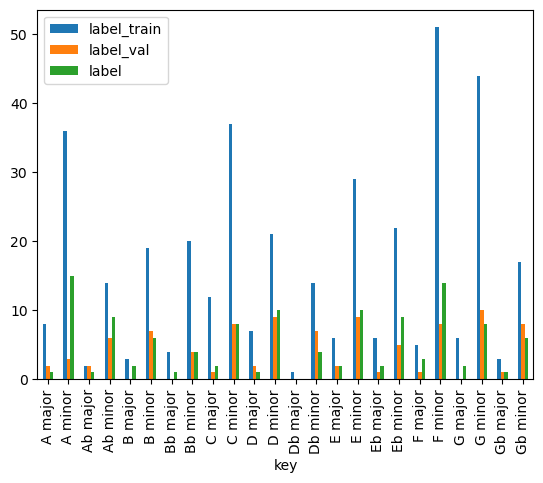

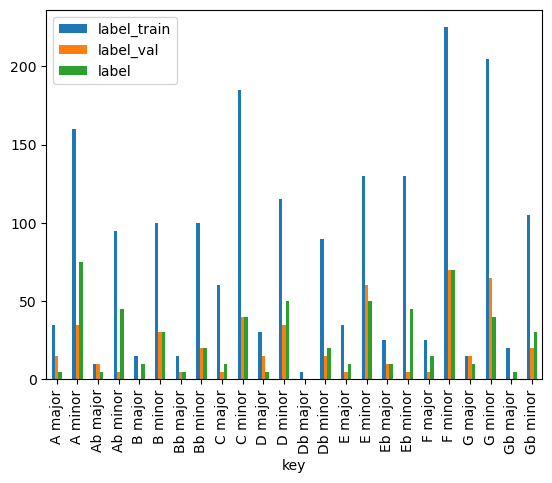

In [13]:
def analyze_label_distribution(keys, partition):
    counts = keys.loc[partition['train'],:].groupby(['key']).count().join(
        keys.loc[partition['val'],:].groupby(['key']).count(), lsuffix='_train', rsuffix='_val').join(
        keys.loc[partition['test'],:].groupby(['key']).count(), rsuffix='_test')
    display(counts)
    counts.plot.bar()
    
analyze_label_distribution(giantsteps_keys, partition)
analyze_label_distribution(segment_keys, partition_segments)

In [29]:
from importlib import reload
import sys
reload(sys.modules['model.Experimental'])
reload(sys.modules['model.Simple'])
reload(sys.modules['model.SpectralDataset'])
from model.Experimental import SplitNet, ColNet
from model.Simple import SimpleTestNet
from model.SpectralDataset import SpectralDataset

In [14]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [31]:
torch.cuda.empty_cache()
#net = SimpleTestNet().to(device)
#net = KeyNet().to(device)
#net = SplitNet().to(device)
net = ColNet().to(device)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer_SGD = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
optimizer_Adam = optim.Adam(net.parameters(), lr=0.00005)

optimizer = optimizer_Adam

max_epochs = 150
callback = 50
best_epoch = 0

min_val_loss = np.inf

intermediate_model_location = root_folder + "model\optimal_weights.pth"

for epoch in range(max_epochs):  # loop over the dataset multiple times
    #print(f"{epoch}/{max_epochs}",end="\r")

    train_loss = 0.0
    net.train()
    for local_batch, local_labels in training_generator:
        
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        inputs = local_batch.float()
        labels = local_labels

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    
    val_loss = 0.0
    net.eval()
    for local_batch, local_labels in validation_generator:
        
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        inputs = local_batch.float()
        labels = local_labels
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

    if val_loss < min_val_loss:
        best_epoch = epoch
        min_val_loss = val_loss
        torch.save(net.state_dict(), intermediate_model_location)
        print(f'[{epoch+1}/{max_epochs}] train loss: {train_loss / len(training_generator)}\t| validation loss: {val_loss / len(validation_generator)} (new optimum)')
    else:
        print(f'[{epoch+1}/{max_epochs}] train loss: {train_loss / len(training_generator)}\t| validation loss: {val_loss / len(validation_generator)}')
        
    if epoch - best_epoch >= callback:
        print(f"No improvement for {callback} epochs - aborting training.")
        break

print('Finished Training')

net.load_state_dict(torch.load(intermediate_model_location))

[1/150] train loss: 0.7097529673576355	| validation loss: 0.709357370932897 (new optimum)
[2/150] train loss: 0.6991530418395996	| validation loss: 0.7070720692475637 (new optimum)
[3/150] train loss: 0.6920446825027465	| validation loss: 0.7016965746879578 (new optimum)
[4/150] train loss: 0.6866876029968262	| validation loss: 0.7028593321641287
[5/150] train loss: 0.6829045724868774	| validation loss: 0.7030421098073324
[6/150] train loss: 0.6813699579238892	| validation loss: 0.7023690740267435
[7/150] train loss: 0.6806075549125672	| validation loss: 0.7014573613802592 (new optimum)
[8/150] train loss: 0.6796147108078003	| validation loss: 0.7016529540220896
[9/150] train loss: 0.6792922639846801	| validation loss: 0.7018207013607025
[10/150] train loss: 0.6788843727111816	| validation loss: 0.701693723599116
[11/150] train loss: 0.6786116647720337	| validation loss: 0.7011217077573141 (new optimum)
[12/150] train loss: 0.6785709929466247	| validation loss: 0.7014967203140259
[13/1

[104/150] train loss: 0.6773202705383301	| validation loss: 0.7003378172715505
[105/150] train loss: 0.6773288321495056	| validation loss: 0.7000653147697449
[106/150] train loss: 0.6773205518722534	| validation loss: 0.6999587714672089
[107/150] train loss: 0.677319564819336	| validation loss: 0.6999327937761942
[108/150] train loss: 0.6773195385932922	| validation loss: 0.6999244491259257
[109/150] train loss: 0.6773192763328553	| validation loss: 0.6998954812685648
[110/150] train loss: 0.6773221874237061	| validation loss: 0.6999343534310659
[111/150] train loss: 0.677318902015686	| validation loss: 0.6999346514542898
[112/150] train loss: 0.6773200178146362	| validation loss: 0.6998710831006368
[113/150] train loss: 0.6773272299766541	| validation loss: 0.7002490063508352
[114/150] train loss: 0.6773208522796631	| validation loss: 0.7001617352167765
[115/150] train loss: 0.6773247814178467	| validation loss: 0.699715793132782
[116/150] train loss: 0.6773255562782288	| validation l

<All keys matched successfully>

Define functions to test accuracy and Mirex score:

In [20]:
def test(dataloader, model, loss_fn, cm):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.float().to(device), y.squeeze().to(device)
            pred = model(X)
            
            test_loss += loss_fn(pred, y).item()
            y_hat = pred.argmax(1)
            y_true = y.argmax(1)
            
            for i,v in enumerate(y_hat):
                cm.loc[v.item(),y_true[i].item()] += 1
            correct += (y_hat == y_true).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return cm

TONICS = ['Ab', 'A', 'Bb', 'B', 'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G']

def compute_mirex_score(key, key_predicted):
    tonic = re.match('^[^\s]+',key).group(0)
    mode = re.search('[^\s]+$',key).group(0)
    
    tonic_predicted = re.match('^[^\s]+',key_predicted).group(0)
    mode_predicted = re.search('[^\s]+$',key_predicted).group(0)
    
    
    idx = TONICS.index(tonic)
    
    # True match
    if tonic == tonic_predicted and mode == mode_predicted:
        return 1
    # Perfect fifth relation
    elif (tonic_predicted == TONICS[(idx+7) % 12] or tonic_predicted == TONICS[idx-7 % 12]) and mode == mode_predicted:
        return 0.5
    # Relative minor/major
    elif (tonic_predicted== TONICS[(idx+3) % 12] and mode == 'minor' and mode_predicted == 'major') or (tonic_predicted == TONICS[(idx-3) % 12] and mode == 'major' and mode_predicted == 'minor'):
        return 0.3
    # Parallel minor/major
    elif tonic == tonic_predicted:
        return 0.2
    else:
        return 0

Test Error: 
 Accuracy: 45.5%, Avg loss: 0.700288 

Test Mirex score: 47.93388429752066


<AxesSubplot: >

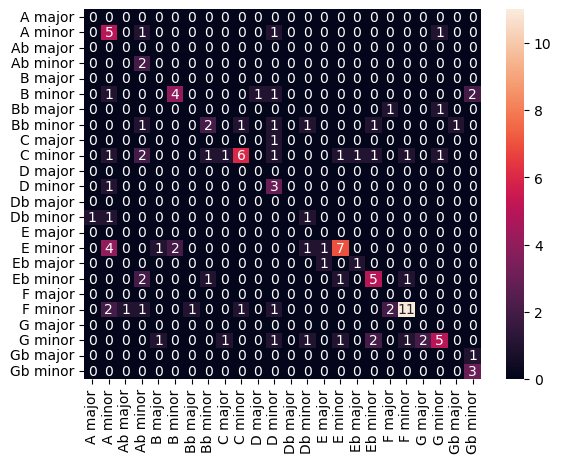

In [32]:
cm = pd.DataFrame(0, index=range(24), columns=range(24))
cm = test(test_generator, net, criterion, cm)
cm.index=le.inverse_transform(cm.index)
cm.columns=le.inverse_transform(cm.columns)

total = cm.sum().sum()
mirex_score = 0
for key in cm.columns:    
    for key_predicted in cm.loc[cm.loc[:,key] > 0, key].index:   
        #print(f"{key} vs {key_predicted}:{compute_mirex_score(key, key_predicted)}")     
        mirex_score += compute_mirex_score(key, key_predicted) * cm.loc[key,key_predicted]
        
print(f"Test Mirex score: {mirex_score/total*100}")

sn.heatmap(cm, annot=True)

In [81]:
x,y = next(iter(test_generator))
x = x.float().to(device)

In [82]:
net.eval()
torch_out = net(x)

In [86]:
torch.onnx.export(net,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                 )

In [92]:
import onnx

onnx_model = onnx.load("super_resolution.onnx")
onnx.checker.check_model(onnx_model)

In [89]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("super_resolution.onnx", providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 2 / 384 (0.521%)
Max absolute difference: 0.00031263
Max relative difference: 0.0025282
 x: array([[3.309345e-05, 3.236885e-05, 4.542285e-04, 3.098485e-04,
        2.999397e-05, 2.453846e-03, 4.380265e-03, 9.058910e-03,
        5.492168e-03, 1.981606e-04, 1.710096e-04, 2.978204e-05,...
 y: array([[3.313815e-05, 3.240436e-05, 4.548084e-04, 3.102995e-04,
        3.004450e-05, 2.457949e-03, 4.386012e-03, 9.074075e-03,
        5.503600e-03, 1.986628e-04, 1.712032e-04, 2.982662e-05,...